This notebook is just here to look at the data we have and to do "pre-preprocessing"

In [2]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#First, function to load the data
DataPath="mit_bih_csv_files/ecg_records/"
def RetrieveData(RecordNum):
    """Retrieves the ecg data from the record provided"""
    ecgData=pd.read_csv(DataPath+str(RecordNum)+"_ecg.csv")
    ecgAnno=pd.read_csv(DataPath+str(RecordNum)+"_annotations.csv")
    return np.array(ecgData),np.array(ecgAnno)

We know the recordings are at 360 per second for MIT - https://physionet.org/content/mitdb/1.0.0/

Let's just look at a 30 second window to view the data - they are segmented in 30 second chunks for 

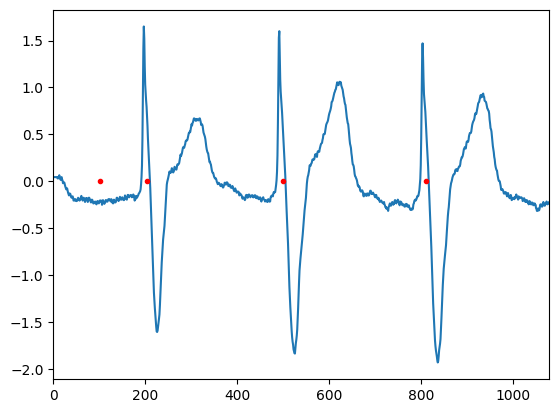

In [4]:
ExampleData,ExampleAnnotations=RetrieveData(217)
ExampleAnnotations2=ExampleAnnotations.copy()
ExampleAnnotations2[:,0]=(ExampleAnnotations[:,0]=="A")+np.zeros(shape=ExampleAnnotations[:,0].shape)

plt.plot(ExampleData[:1080,0]) #3 seconds
plt.plot(ExampleAnnotations2[:,1],ExampleAnnotations2[:,0],"r.")
plt.xlim(0,1080)
plt.show()

Now that we can visualise the data a bit, let's try and process the data into the format we've agreed on

In [5]:
colNumforECG=0 #The column index for the ECG channel we are picking - either 0 or 1
Seconds=3 #The number of seconds we look at
MaxNumBeats=15 #The maximum number of beats per window

MaxNumBeats=MaxNumBeats*2
TimeFrame=Seconds*360

def ConvertAnnos(Anno,Intervals):
    """Takes annotation data and returns a labels within the intervals"""
    ReturnAnnotations=np.ndarray.flatten(Anno[Anno[:,1]<=TimeFrame])
    ReturnAnnotations=[np.pad(ReturnAnnotations,pad_width=(0,MaxNumBeats-len(ReturnAnnotations)))]
    for j,i in enumerate(Intervals[:-1]):
        AddArray=np.ndarray.flatten(Anno[(Anno[:,1]<=Intervals[j+1])*(Anno[:,1]>=i)])
        if len(AddArray)>MaxNumBeats:
            print(AddArray)
        ReturnAnnotations=np.append(ReturnAnnotations,[np.pad(AddArray,pad_width=(0,MaxNumBeats-len(AddArray)))],axis=0)
    return ReturnAnnotations


def ProcessECGData(Data,Anno):
    """Takes ECG data and the annotations and outputs a matrix with t second chunks with an annotation at the end"""
    #Intervals:
    Intervals=np.arange(TimeFrame,Data.shape[0],TimeFrame)
    NewData=Data[0:TimeFrame][:,np.newaxis].T #New data is our data that is segmented into 30 second chunks
    Labels=ConvertAnnos(Anno,Intervals)
    for j,i in enumerate(Intervals[:-1]):
        NewData=np.append(NewData,[Data[i:Intervals[j+1]]],axis=0)
    NewData=np.append(NewData,Labels,axis=1)
    return NewData

def RetrievePatientData(Num):
    Data,Annotation=RetrieveData(Num)
    return ProcessECGData(Data[:,colNumforECG],Annotation)

RetrievePatientData(101).shape


(601, 1110)

In [20]:
#Now we have the functions, we can do this for each number
#Numbers: 100-124, 200-234
import os #Just to get the file names
fileNames=os.listdir(DataPath)
df=pd.DataFrame(RetrievePatientData(100))
for fileIndex in np.arange(3,len(fileNames),3):
    Num=fileNames[fileIndex][:3]
    df2=pd.DataFrame(RetrievePatientData(Num))
    df=pd.concat([df,df2],ignore_index=True)

df.shape

(28848, 1110)

In [7]:
#df.to_csv("MIT30Sec.csv") 

In [23]:
MaxNumofAnnotations=5 # This is the maximum number of beats that we want to classify in the time frame

df=df[df[TimeFrame+(1+MaxNumofAnnotations)*2]==0] #Gets rid of any lines that are more than those annotations

df=df.loc[:, (df != 0).any(axis=0)]
df.shape


(28505, 1092)

In [24]:
#Save the dataframe
df.to_csv("MIT3sec.csv")